In [1]:
import numpy as np 
import pathlib 
import h5py
import os
import datetime 
import pandas as pd
import warnings
import scipy
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
# import seaborn_image as isns
sns.set_theme()
sns.set_style("whitegrid")
import os 
import napari
import skimage.measure
import copy
import math
import natsort
import joblib
from joblib import Parallel, delayed

import space
import plotting
import temporal
import utilities
import filehandling
import utilities
import unit_conversion
import contouring
from utilities import multicolour_reshape as reshape 
import signal_analysis
import data_objects

import pickle
from collections.abc import Iterable
# qgrid.enable() 
# import pandasgui
# import tabloo

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# %matplotlib widget
# plt.ioff()
# Lazy define some plotting params
chromatic_palette = ['red', 'green', 'blue', 'violet'] # R G B UV
rgbuv_palette = ['red', 'green', 'violet']
chromatic_hues = ["R", "G", "B", "UV"]

achromatic_palette = ['black', 'brown'] # BW BWnoUV 
achromatic_hues = ["BW", "BWnoUV"]
all_palette = chromatic_palette + achromatic_palette
all_hues = ["R", "G", "B", "UV", "BW", "BWnoUV"]
rguv_hues = ["R", "G", "UV"]
nanometers = ["588", "478", "422", "375"]
fish_palette = ["orange", "royalblue","blueviolet", "fuchsia"]

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
sns.set_context("notebook")
matplotlib.rcParams['svg.fonttype'] = 'none'

%reload_ext autoreload
%autoreload 2

# TODO list

## Clean up STRF class
Use the principles from the other dataclasses, such that attributes reflect data structures and methods reflect actions you can do with/to the data --> Keeping in mind lazy computing for STRF classes, of course

- [ ] Get attributes and methods seperated correctly (prioritise, might as well clean up immediate issues while doing this)
- [ ] Implement class access to plotting functions 
- [ ] Implement class access to things like clustering pipeline 

## Clean up and tidy clustering scripts 
Currently, the clustering works, and it works quite nicely, but the way its written is chaotic and error prone. What I need to do is go through and formalise the steps of pre-processing and clustering into discrete functions, such that each step could be pulled individually (this will hopefully lead to a natural solution to the dataframe + pca return problem)

- [ ] Tidy up, formalise, and give access to intermidate steps via functions (should be accesible via the dataclass)
- [ ] Make a simple solution for pulling data by cluster, e.g. from the final DataFrame
- [ ] Check if it makes sense to write clustering labels directly to data objects
    - Forseable problem: for clustering to work you need "global?" access to all data files, and therefore retroactively applying cluster labels might not be exteremly useful. Weight the effort vs outcome, and see if worth it 

In [2]:
import data_objects_beta
test = data_objects_beta.STRF(r"C:\Users\Simen\Downloads\2023-11-14_0_0_SWN_200_Colours.h5", bs_bool = True)
#test.run_bootstrap()

c:\Users\Simen\OneDrive\Universitet\PhD\GitHub repos\RF_project\data_objects_beta.py:545: UserWarning: Rotation detected and corrected for C:\Users\Simen\Downloads\2023-11-14_0_0_SWN_200_Colours.h5
  self.strfs = data_helpers.load_strf(HDF5_file)


In [3]:
help(test.contours_area)

Help on method contours_area in module data_objects_beta:

contours_area(scaling_factor=1) -> list method of data_objects_beta.STRF instance
    Generate the area for each contour in the list of contours using the contours_area_bipolar function with a specified scaling factor.
    
    Parameters:
        scaling_factor (int): A scaling factor to adjust the area calculation (default is 1).
    
    Returns:
        list: A list of areas for each contour in the list.



In [ ]:
test.

In [4]:
test.get_help(types=True)


Welcome to your data object! 
Below are attributes and methods, as well as some metadata.
Pass 'hint = True' for more tips and hints on using the data class.
    ## Class info:
        Current data type: 
        ['STRF']
        Current metadata: 
       { 'exp_date': datetime.date(2023, 11, 14),
         'exp_time': datetime.time(16, 16, 15),
         'filename': 'C:\\Users\\Simen\\Downloads\\2023-11-14_0_0_SWN_200_Colours.h5',
         'objectiveXYZ': (-126820.0, -74368.0, -124050.0)}

    ## Attributes
        Here's the data you have access to -> pass 'types = True' for type hints, attr (type):
    [ 'averages (float)', 'bs_bool (bool)', 'bs_settings (dict)', 'data_types (list)', 'filename (WindowsPath)',
      'frame_hz (float)', 'images (ndarray)', 'ipl_depths (ndarray)', 'metadata (dict)', 'ms_dur (float)',
      'multicolour (bool)', 'name (str)', 'num_rois (int)', 'num_strfs (int)', 'numcolour (int)',
      'phase_num (int)', 'rois (ndarray)', 'snippets (float)', 'strf_keys 

In [ ]:
t

In [5]:
test.set_default_bootstrap_settings()
test.get_bootstrap_settings()

{'do_bootstrap': True,
 'time_sig_thresh': 0.1,
 'space_sig_thresh': 0.1,
 'space_bs_n': 1000,
 'time_bs_n': 2500,
 'bs_already_ran': False,
 'bs_datetime': datetime.datetime(2024, 4, 1, 15, 59, 6, 689093),
 'bs_datetime_str': '01/04/24 15:59:06',
 'bs_dur_timedelta': ''}

In [9]:
update_dict = {
    "do_bootstrap" : True,
    "space_bs_n" : 100,
    "time_bs_n" : 250,
}
test.update_bootstrap_settings(update_dict)
test.get_bootstrap_settings()

{'do_bootstrap': True,
 'time_sig_thresh': 0.1,
 'space_sig_thresh': 0.1,
 'space_bs_n': 100,
 'time_bs_n': 250,
 'bs_already_ran': False,
 'bs_datetime': datetime.datetime(2024, 4, 1, 15, 59, 6, 689093),
 'bs_datetime_str': '01/04/24 15:59:06',
 'bs_dur_timedelta': ''}

In [10]:
test.pvals_table()

p value for space bootstrap did not exist, just making that now


Hang on, bootstrapping spatial components 100 times:   0%|          | 0/44 [00:00<?, ?it/s]

p value for time bootstrap did not exist, just making that now


Hang on, bootstrapping temporal components 250 times:   0%|          | 0/44 [00:00<?, ?it/s]

space_R space_G space_B space_UV time_R time_G time_B time_UV  sig_R  \
0      0.0     0.0    0.46     0.41  0.012  0.008  0.892   0.732   True   
1      0.0     0.0     1.0      0.0  0.004  0.268  0.496   0.028   True   
2      0.0     0.0     0.0     0.37  0.012  0.116  0.904    0.32   True   
3      0.0     0.0    0.81     0.04    0.0  0.016  0.272   0.388   True   
4      0.0     0.0     0.0      0.0  0.012  0.012    0.0    0.02   True   
5      0.0     0.0     0.0      0.0    0.0  0.076  0.052     0.0   True   
6      0.0    0.08     0.0      0.0  0.028  0.336  0.068   0.004   True   
7      0.1    0.12     0.0      0.0  0.664  0.144    0.0   0.008  False   
8      0.0     0.0    0.07      0.0  0.004  0.164   0.02   0.012   True   
9      0.0     0.6    0.01      0.0  0.524  0.164    0.0     0.0  False   
10     0.0     0.0     0.0      0.0    0.0  0.168   0.02   0.004   True   

    sig_G  sig_B sig_UV  
0    True  False  False  
1   False  False   True  
2   False  False  False  
3    True  False  False  
4    True   True   True  
5    True   True   True  
6   False   True   True  
7   False   True   True  
8   False   True   True  
9   False   True   True  
10  False   True   True

In [11]:
test.contours()

array([[list([array([[13.        , 22.14796989],
               [12.        , 22.79920504],
               [11.30966935, 23.        ],
               [11.        , 23.13420011],
               [10.        , 23.08893616],
               [ 9.86924894, 23.        ],
               [ 9.03147683, 22.        ],
               [ 9.        , 21.61218624],
               [ 8.95444045, 21.        ],
               [ 8.930495  , 20.        ],
               [ 9.        , 19.84124589],
               [ 9.34159206, 19.        ],
               [10.        , 18.31827215],
               [11.        , 18.0360197 ],
               [12.        , 18.32394222],
               [13.        , 18.92867169],
               [13.06504299, 19.        ],
               [13.60977813, 20.        ],
               [13.8319398 , 21.        ],
               [13.16158765, 22.        ],
               [13.        , 22.14796989]])])   , list([])],
       [list([array([[13.        , 21.32450076],
               [12.13478

In [113]:
test.pval_space()

p value for space bootstrap did not exist, just making that now


Hang on, bootstrapping spatial components 1000 times:   0%|          | 0/44 [00:00<?, ?it/s]

c:\Users\Simen\miniconda3\envs\strf\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [326]:
test.help(types=True)


Welcome to your Data object!
    ## Class info:
        Current data types: 
        ['STRF']
        Current metadata: 
       { 'exp_date': datetime.date(2023, 11, 14),
         'exp_time': datetime.time(16, 16, 15),
         'filename': 'C:\\Users\\Simen\\Downloads\\2023-11-14_0_0_SWN_200_Colours.h5',
         'objectiveXYZ': (-126820.0, -74368.0, -124050.0)}

    ## Attributes
        Here's the data you have access to -> attr (type):
    [ 'averages (float)', 'bs_bool (bool)', 'bs_settings (dict)', 'data_types (list)', 'filename (WindowsPath)',
      'frame_hz (float)', 'images (ndarray)', 'ipl_depths (ndarray)', 'metadata (dict)', 'ms_dur (float)',
      'multicolour (bool)', 'name (str)', 'num_rois (int)', 'num_strfs (int)', 'numcolour (int)',
      'phase_num (int)', 'rois (ndarray)', 'snippets (float)', 'strf_keys (list)', 'strfs (MaskedArray)',
      'trigger_mode (int)', 'triggerstimes_frame (ndarray)', 'triggertimes (ndarray)', 'type (str)']
    
    ## Methods
        Her

TypeError: 'float' object is not subscriptable

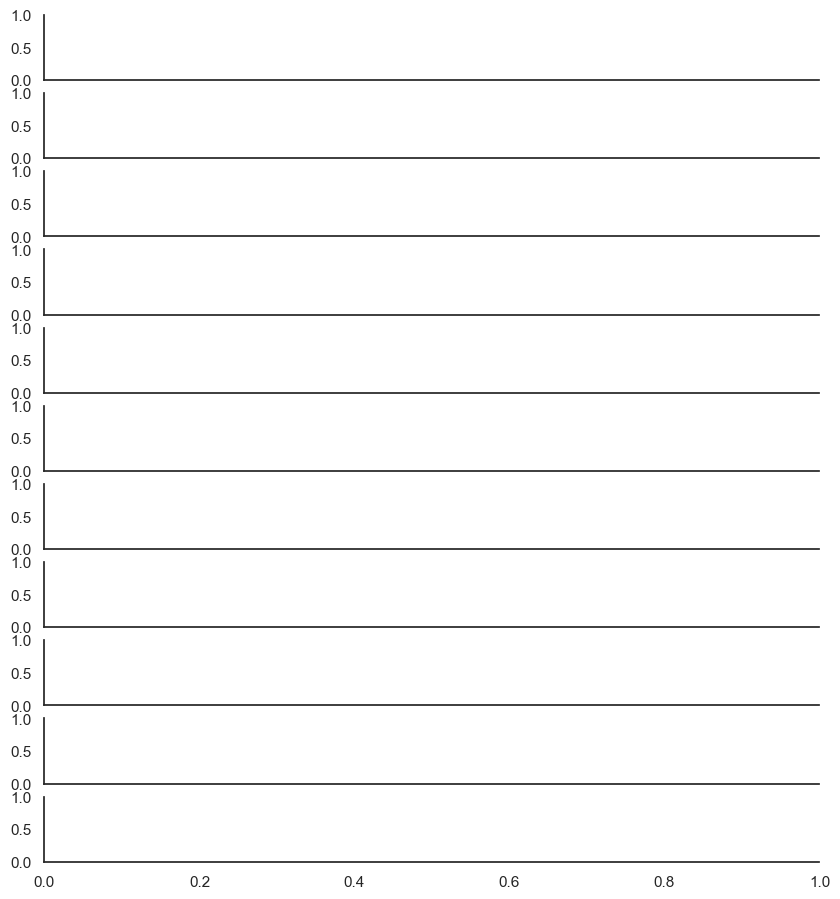

In [7]:
test.plot_averages()

In [216]:
asd = (1,2,3)
org_type = type(asd)
org_type("aooha")

('a', 'o', 'o', 'h', 'a')

In [198]:
isinstance("asd", Iterable)

True

In [50]:
test.run_bootstrap()

Hang on, bootstrapping temporal components 2500 times:   0%|          | 0/44 [00:00<?, ?it/s]

Hang on, bootstrapping spatial components 1000 times:   0%|          | 0/44 [00:00<?, ?it/s]

In [48]:
test.bs_settings["do_bootstrap"] = True

In [49]:
test.pval_time

p value for time bootstrap did not exist, just making that now


Hang on, bootstrapping temporal components 2500 times:   0%|          | 0/44 [00:00<?, ?it/s]

In [79]:
import helpinfo
helpinfo.print_help.__annotations__.get('return', '?')

'?'

In [66]:
 [func + f" {type(getattr(test, func))}" for func in dir(test) if callable(getattr(test, func)) if "__" not in func]

["amplitude_tuning_functions <class 'method'>",
 "area_tuning_functions <class 'method'>",
 "calc_LED_offset <class 'method'>",
 "calculate_average_images <class 'method'>",
 "centroid_tuning_functions <class 'method'>",
 "check_ipl_orientation <class 'method'>",
 "collapse_times <class 'method'>",
 "contours_area <class 'method'>",
 "contours_count <class 'method'>",
 "dominant_timecourses <class 'method'>",
 "help <class 'method'>",
 "opponency_bool <class 'method'>",
 "peaktime_tuning_functions <class 'method'>",
 "plot_averages <class 'method'>",
 "plot_chromatic_overview <class 'method'>",
 "polarities <class 'method'>",
 "polarity_category <class 'method'>",
 "pvals_table <class 'method'>",
 "rf_masks <class 'method'>",
 "rf_masks_combined <class 'method'>",
 "run_bootstrap <class 'method'>",
 "save_pkl <class 'method'>",
 "spectral_centroids <class 'method'>",
 "spectrums <class 'method'>",
 "strf_masks <class 'method'>",
 "timecourses_noncentred <class 'method'>",
 "view_drift 

In [51]:
test.help()


Welcome to your Data object!
    ## Class info:
        Current data types: 
        ['STRF']
        Current metadata: 
       { 'exp_date': datetime.date(2023, 11, 14),
         'exp_time': datetime.time(16, 16, 15),
         'filename': 'C:\\Users\\Simen\\Downloads\\2023-11-14_0_0_SWN_200_Colours.h5',
         'objectiveXYZ': (-126820.0, -74368.0, -124050.0)}

    ## Attributes
        Here's the data you have access to:
    [ 'averages', 'bs_bool', 'bs_settings', 'contours', 'contours_centres',
      'contours_centres_by_pol', 'contours_centroids', 'contours_complexities',
      'data_types', 'filename', 'frame_hz', 'images', 'ipl_depths', 'metadata',
      'ms_dur', 'multicolour', 'name', 'num_rois', 'num_strfs', 'numcolour',
      'phase_num', 'pval_space', 'pval_time', 'rois', 'snippets', 'space_bs_n',
      'space_sig_thresh', 'strf_keys', 'strfs', 'time_bs_n', 'time_sig_thresh',
      'timecourses', 'trigger_mode', 'triggerstimes_frame', 'triggertimes', 'type']
    
    ## Me

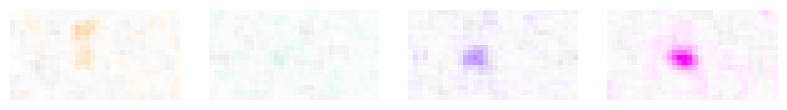

In [197]:
plotting.chroma_overview(test, specify_rois=[6])

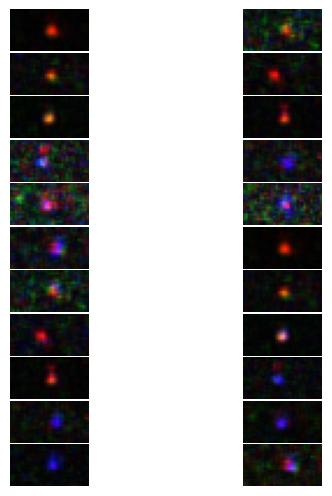

In [204]:
plotting.rgb_representation(test, specify_rois=None)

In [158]:
np.arange(0, 4)

array([0, 1, 2, 3])

In [34]:
test.numcolour

4

In [2]:
roi = 10
plotting.visualise_summary(loadfile, roi)
plotting.chroma_overview(loadfile, roi);

NameError: name 'loadfile' is not defined

In [123]:
swn_files = filehandling.find_files_in(".h5" , "D:\Igor analyses", match_all = ["Colour", "SWN"], recursive=True)
swn_files

[WindowsPath('D:/Igor analyses/SWN/230613/0_0_ColorSWN_200_0/2023-6-13_0_0_ColourSWN_200_0.h5'),
 WindowsPath('D:/Igor analyses/SWN/230613/0_1_ColorSWN_200_0/2023-6-13_0_1_ColourSWN_200_0.h5'),
 WindowsPath('D:/Igor analyses/SWN/230614/0_1_ColorSWN_200_0/2023-6-14_SMP_0_2_ColourSWN_200_0.h5'),
 WindowsPath("D:/Igor analyses/SWN/230614/0_2_ColorSWN_200_0/2023-6-14_'0_2_ColourSWN_200_0'.h5"),
 WindowsPath("D:/Igor analyses/SWN/230718/0_1_ColorSWN_200_0/2023-7-18_'0_1_ColourSWN_200_0'.h5"),
 WindowsPath('D:/Igor analyses/SWN/230718/0_4_ColorSWN_200_0/2023-7-18_ColourSWN_200_0_4.h5'),
 WindowsPath("D:/Igor analyses/SWN/230731/0_1_ColourSWN_200_0/2023-7-31_'0_1_ColourSWN_200_0'.h5"),
 WindowsPath("D:/Igor analyses/SWN/230801/0_0_ColourSWN_0/2023-8-1_'0_0_ColourSWN_200_0'.h5"),
 WindowsPath("D:/Igor analyses/SWN/230802/0_1_ColourSWN_0/2023-8-2_'0_1_ColourSWN_200_0'.h5"),
 WindowsPath("D:/Igor analyses/SWN/230802/0_1_ColourSWN_1H/2023-8-2_'0_1_ColourSWN_200_1H'.h5"),
 WindowsPath('D:/Igor ana

In [ ]:
import data

In [124]:
obj = data_objects.Data_STRF(swn_files[0])

c:\Users\SimenLab\OneDrive\Universitet\PhD\GitHub repos\RF_project\data_objects.py:547: UserWarning: Rotation detected and corrected for D:\Igor analyses\SWN\230613\0_0_ColorSWN_200_0\2023-6-13_0_0_ColourSWN_200_0.h5
  self.strfs = load_strf(HDF5_file)


In [126]:
plotting.chroma_overview(obj) 

c:\Users\SimenLab\OneDrive\Universitet\PhD\GitHub repos\RF_project\contouring.py:183: UserWarning: Passed array did not meet absolute threshold criteria of 1
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)


Hang on, bootstrapping temporal components 2500 times:   0%|          | 0/236 [00:00<?, ?it/s]

KeyboardInterrupt: 

Have changed paramteres within polarity_neat inside filehandling.py to force polarity depending on which "side" of the tuple a signal is detected, regardless of whether that signals has a postiive polarity or negative polarity. Not sure yet if this is a good solution and requires manually going through examples. Additionally, noted that object.polarity_category() assigns 'off' when everything is nans, so need to look into that.

All in all, should think about whether the underlying polarity "engine" ise the way to go about this, as there is quite a lot of bugs and exceptions here. 


In [3]:
filehandling.picklestore_objects(swn_files, r"D:\New_pkls\24March19")

Iterating through, loading, and storing listed files as objects:   0%|          | 0/16 [00:00<?, ?it/s]

Output()

In [16]:
# user = pathlib.Path(os.getcwd()).parts
pkl_files = filehandling.find_files_in(".pkl", r"D:\New_pkls\24March19")
# user
pkl_files

[WindowsPath('D:/New_pkls/24March19/2023-11-14_0_0_SWN_200_Colours.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-11-7_0_0_ColourSWN_200.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-11-7_0_2_ColourSWN_200_1.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-11-7_MP_0_3_ColourSWN_200_.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-11-8_MP_0_0_ColourSWN_200_.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-6-13_0_0_ColourSWN_200_0.pkl'),
 WindowsPath('D:/New_pkls/24March19/2023-6-13_0_1_ColourSWN_200_0.pkl'),
 WindowsPath("D:/New_pkls/24March19/2023-6-14_'0_2_ColourSWN_200_0'.pkl"),
 WindowsPath('D:/New_pkls/24March19/2023-6-14_SMP_0_2_ColourSWN_200_0.pkl'),
 WindowsPath("D:/New_pkls/24March19/2023-7-18_'0_1_ColourSWN_200_0'.pkl"),
 WindowsPath('D:/New_pkls/24March19/2023-7-18_ColourSWN_200_0_4.pkl'),
 WindowsPath("D:/New_pkls/24March19/2023-7-31_'0_1_ColourSWN_200_0'.pkl"),
 WindowsPath("D:/New_pkls/24March19/2023-8-1_'0_0_ColourSWN_200_0'.pkl"),
 WindowsPath("D:/New_pkls/24March19/202

In [2]:
pkl_files = filehandling.find_files_in(".pkl", r"D:\New_pkls\24March19")
print(pkl_files)
roi_df, rec_df, chroma_df = filehandling.compile_chroma_strf_df(pkl_files, do_bootstrap = True) #, store_objects="D:\Pickles")
# roi_df, rec_df, chroma_df = filehandling.compile_chroma_strf_df(files, do_bootstrap = True, store_objects="D:\Pickles")
# Clearly, IPL_depths nan-ing is borked so you MUST have it otherwise the DFs are not the same size. Not bad, but a bit confusing
#rec_df.to_pickle(r"D:\DataFrames\rec_df.pkl") 
#chroma_df.to_pickle(r"D:\DataFrames\chroma_df.pkl")

[WindowsPath('D:/New_pkls/24March19/2023-11-14_0_0_SWN_200_Colours.pkl'), WindowsPath('D:/New_pkls/24March19/2023-11-7_0_0_ColourSWN_200.pkl'), WindowsPath('D:/New_pkls/24March19/2023-11-7_0_2_ColourSWN_200_1.pkl'), WindowsPath('D:/New_pkls/24March19/2023-11-7_MP_0_3_ColourSWN_200_.pkl'), WindowsPath('D:/New_pkls/24March19/2023-11-8_MP_0_0_ColourSWN_200_.pkl'), WindowsPath('D:/New_pkls/24March19/2023-6-13_0_0_ColourSWN_200_0.pkl'), WindowsPath('D:/New_pkls/24March19/2023-6-13_0_1_ColourSWN_200_0.pkl'), WindowsPath("D:/New_pkls/24March19/2023-6-14_'0_2_ColourSWN_200_0'.pkl"), WindowsPath('D:/New_pkls/24March19/2023-6-14_SMP_0_2_ColourSWN_200_0.pkl'), WindowsPath("D:/New_pkls/24March19/2023-7-18_'0_1_ColourSWN_200_0'.pkl"), WindowsPath('D:/New_pkls/24March19/2023-7-18_ColourSWN_200_0_4.pkl'), WindowsPath("D:/New_pkls/24March19/2023-7-31_'0_1_ColourSWN_200_0'.pkl"), WindowsPath("D:/New_pkls/24March19/2023-8-1_'0_0_ColourSWN_200_0'.pkl"), WindowsPath("D:/New_pkls/24March19/2023-8-2_'0_1_Co

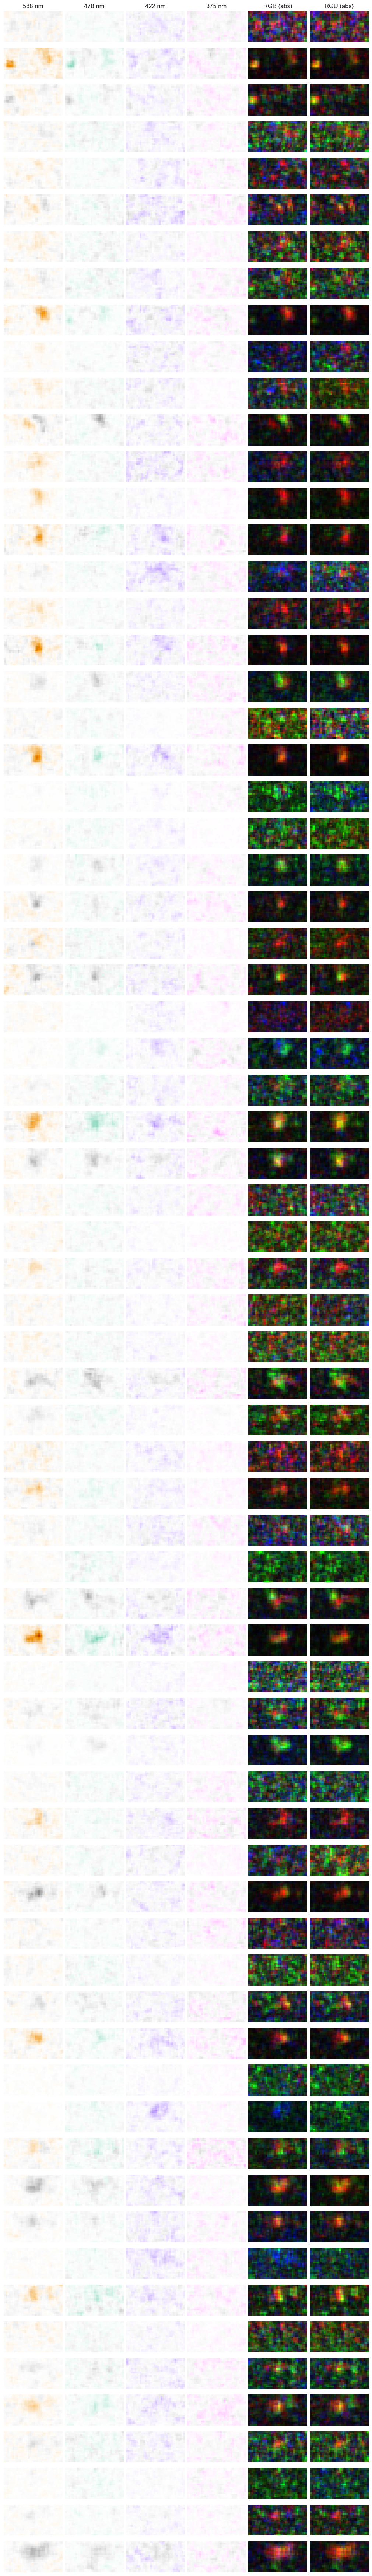

In [130]:
plotting.chroma_overview(filehandling.load(pkl_files[1])) 

# Clustering 

In [3]:
# from sklearn.cluster import KMeans, OPTICS, DBSCAN, AgglomerativeClustering
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# from sklearn.decomposition import PCA
# # Import the sklearn function
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
# from clustering import *

load_df = chroma_df.copy()
split_df = filehandling.split_df_by(load_df, "cat_pol")

### Data exploration 

C:\Users\SimenLab\AppData\Local\Temp\ipykernel_22572\3327149436.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = load_df.corr()


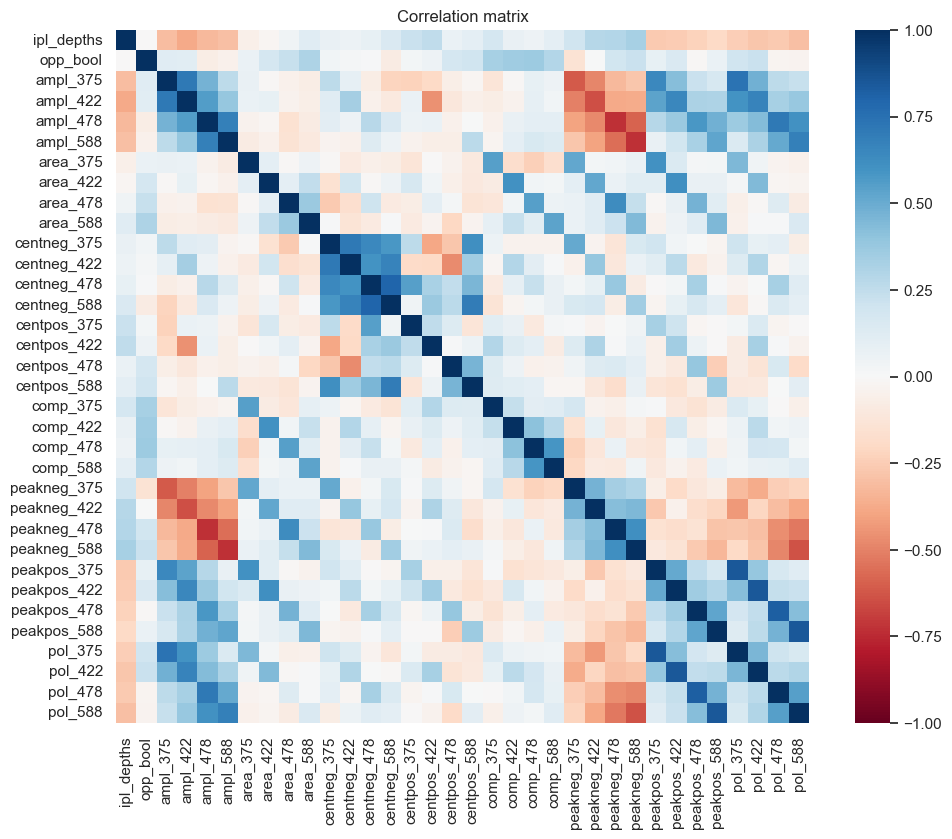

In [328]:
corrmat = load_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax = 1, vmin = -1, square=True, cmap="RdBu")
plt.title("Correlation matrix");

C:\Users\SimenLab\AppData\Local\Temp\ipykernel_22572\825839970.py:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = load_df.cov()


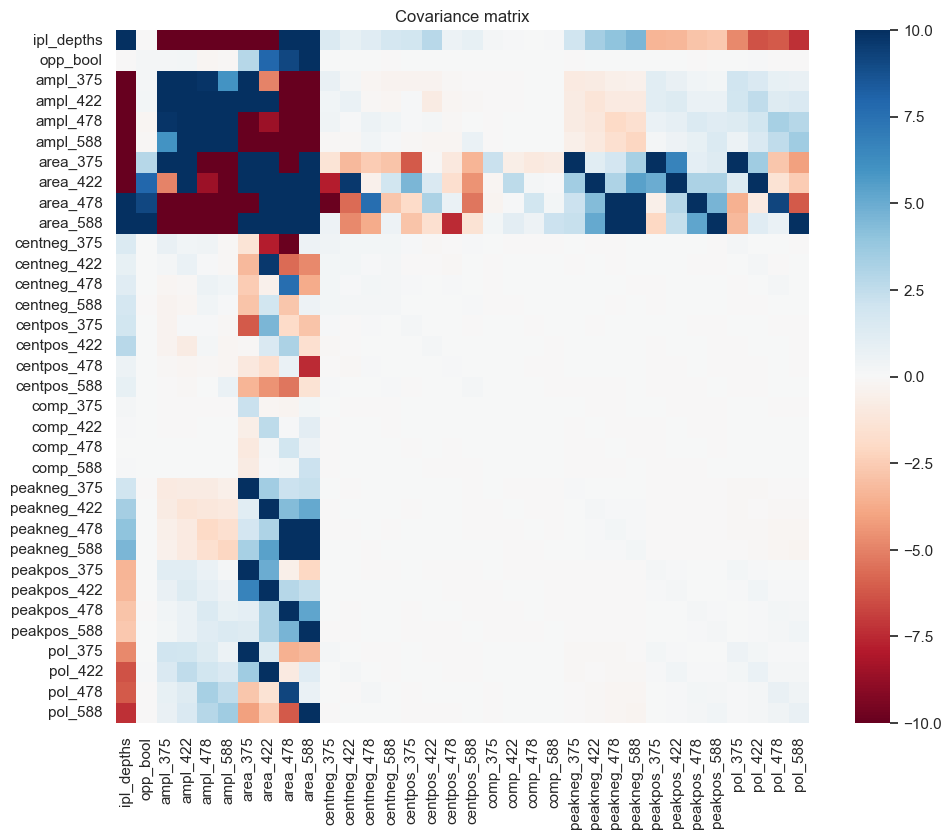

In [329]:
corrmat = load_df.cov()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin = -10, vmax = 10, square=True, cmap="RdBu")
plt.title("Covariance matrix");

Assumptions for PCA according to paper:
1. Underlying patterns must exist and be independent of one another 
2. Must combine linearly to form observed data (linear relationship)
3. Data must contain exclusively these patterns and additive, uncorrelated noise 
4. Observations must be independent

Check and justification:
1. as


[]

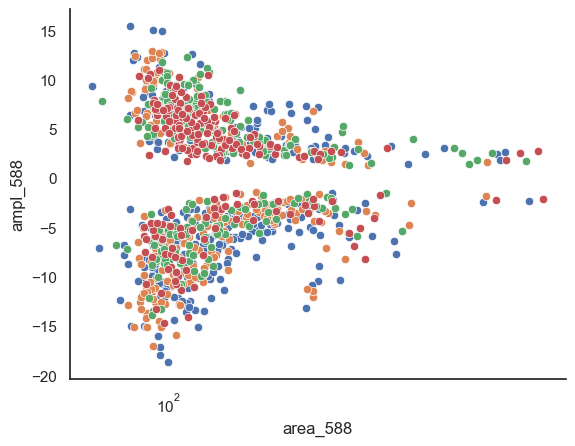

In [11]:
fig, ax = plt.subplots()
for i in ["588", "478", "422", "375"]:
    sns.scatterplot(load_df, x = f"area_{i}", y = f"ampl_{i}", ax= ax)
#ax.set_yscale("log")
ax.semilogx()

## Cluster

## Post-PCA Clustering

In [3]:
import clustering

Automatic number determined as AIC = -9476.46887153406 landing on covariance_type = full with  12 n_components
Automatic number determined as AIC = -16560.241072280565 landing on covariance_type = full with  6 n_components
Automatic number determined as AIC = -19729.48033905204 landing on covariance_type = full with  9 n_components
Automatic number determined as AIC = -6030.620238634216 landing on covariance_type = full with  7 n_components


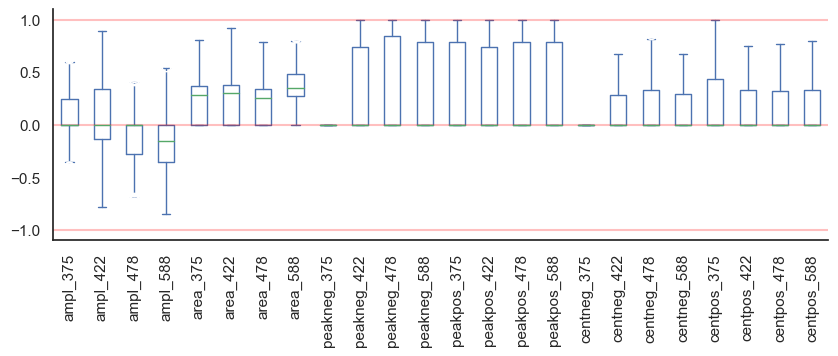

In [4]:
load_df = chroma_df.copy()
pca_df, scaled_df, stats_df, pca_results = clustering.run_clustering(load_df)

In [136]:
stats_df.columns

Index(['index', 'ampl_375', 'ampl_422', 'ampl_478', 'ampl_588', 'area_375',
       'area_422', 'area_478', 'area_588', 'peakneg_375', 'peakneg_422',
       'peakneg_478', 'peakneg_588', 'peakpos_375', 'peakpos_422',
       'peakpos_478', 'peakpos_588', 'centneg_375', 'centneg_422',
       'centneg_478', 'centneg_588', 'centpos_375', 'centpos_422',
       'centpos_478', 'centpos_588', 'cluster_id', 'cluster', 'cat_pol',
       'ipl_depths', 'path', 'filename', 'date', 'curr_path', 'roi', 'cell_id',
       'spatial_588', 'spatial_478', 'spatial_422', 'spatial_375', 'spatial_X',
       'spatial_Y', 'temporal_588', 'temporal_478', 'temporal_422',
       'temporal_375'],
      dtype='object')

In [153]:
roi_df.shape[0]/4

453.0

In [150]:
plotting.ipl_summary_chroma(roi_df)

UserWarning: Fix 'cell_ID' implementation in roi_df

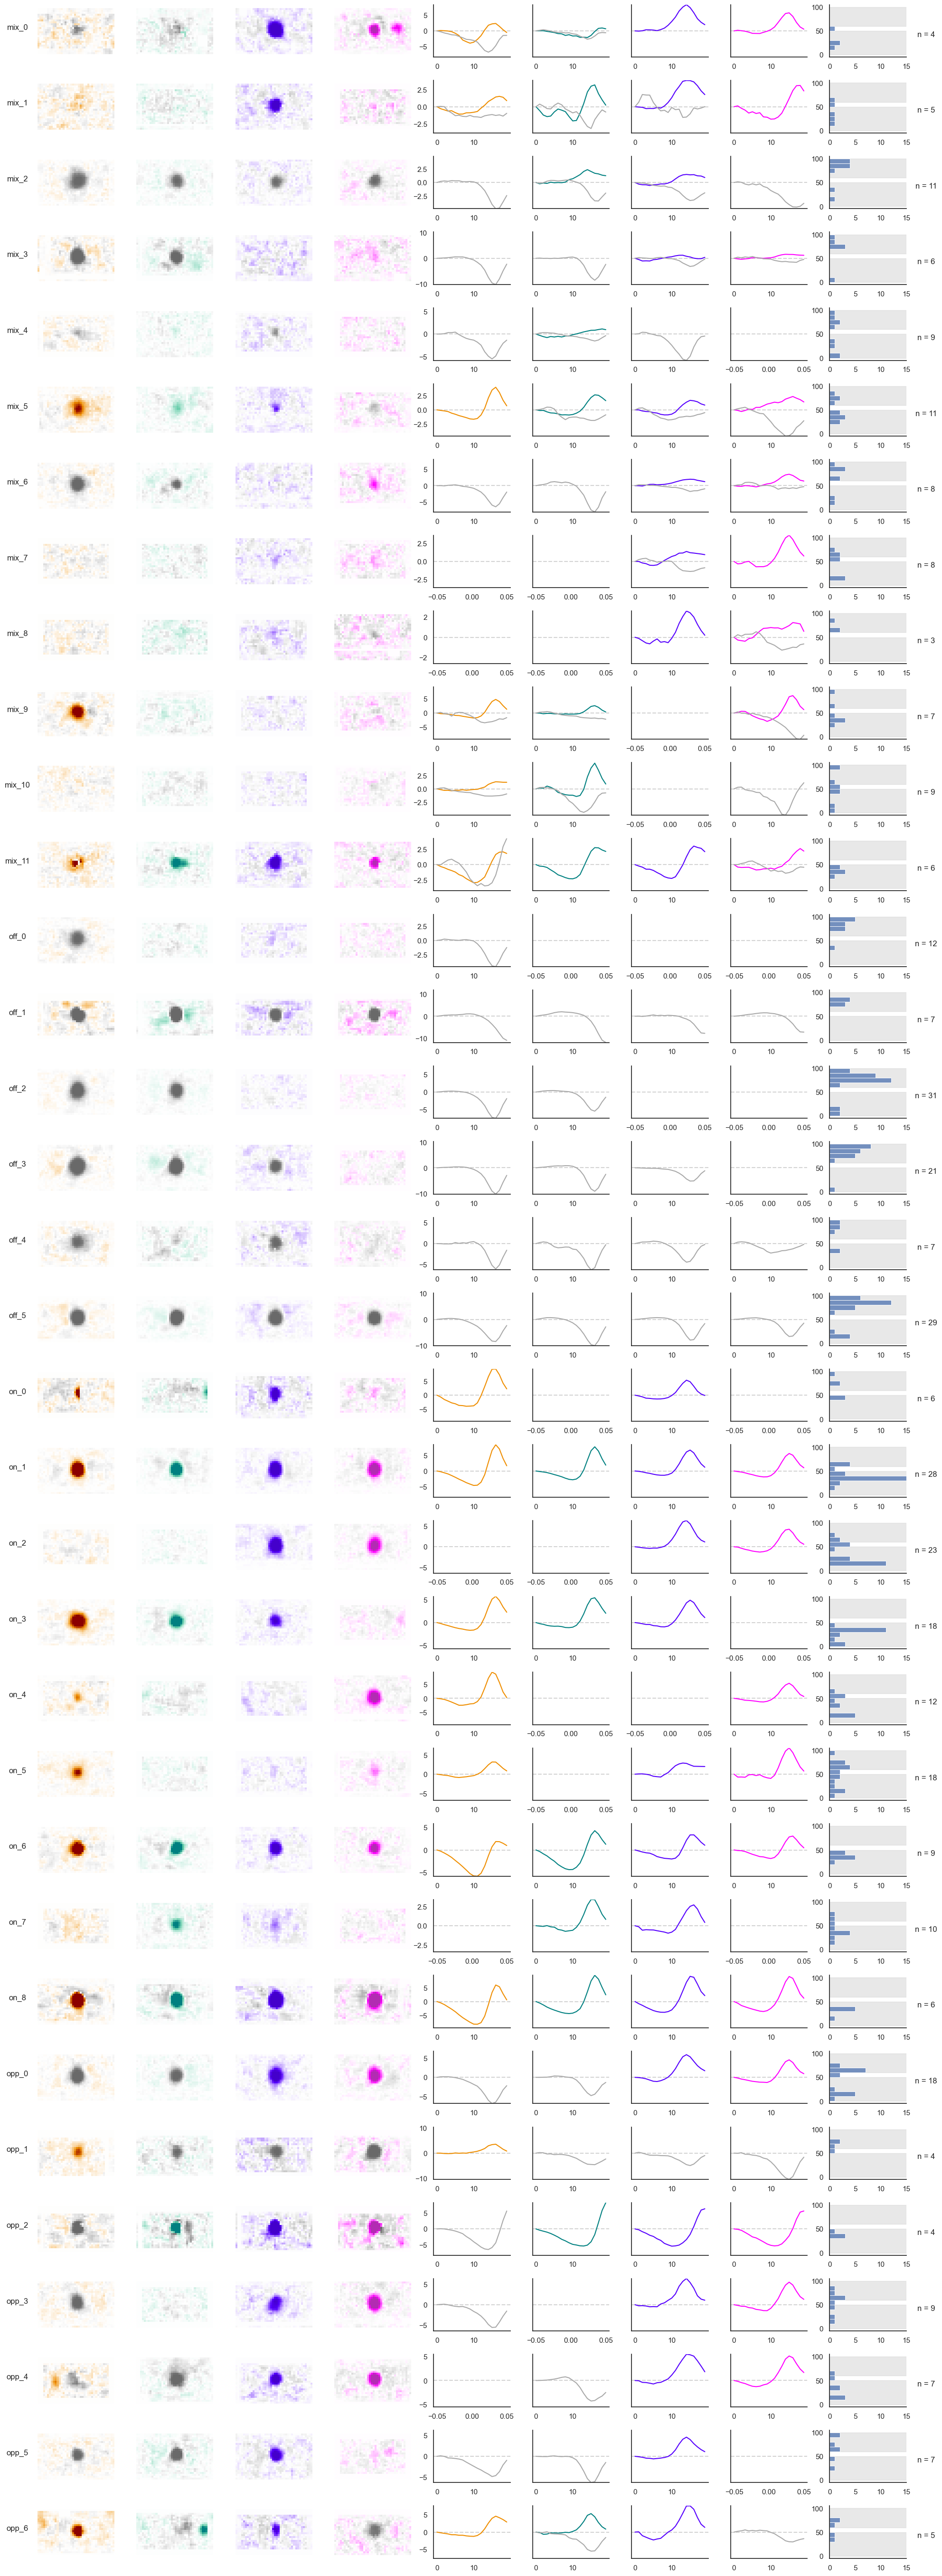

In [115]:
cluster_ids = natsort.natsorted(stats_df["cluster_id"].unique())
scale = 2
fig, ax = plt.subplots(len(cluster_ids), 9, figsize = (10*scale, len(cluster_ids)*scale/1.25) , sharex=False, sharey=False)
for n, clust in enumerate(cluster_ids):
    # Prep for plotting
    Rarrs = []
    Garrs = []
    Barrs = []
    UVarrs = []
    Rtimes = []
    Gtimes = []
    Btimes = []
    UVtimes = []
    ipls = []
    # Get the files and rois
    files = []
    rois = []
    # Loop through matches in the cluster, per ROI (iloc)
    for df in stats_df.query(f"cluster_id == '{clust}'").iloc:
        Rarrs.append(df["spatial_588"])
        Garrs.append(df["spatial_478"])
        Barrs.append(df["spatial_422"])
        UVarrs.append(df["spatial_375"])
        Rtimes.append(df["temporal_588"])
        Gtimes.append(df["temporal_478"])
        Btimes.append(df["temporal_422"])
        UVtimes.append(df["temporal_375"])
        files.append(df["curr_path"])
        rois.append(df["roi"])
        ipls.append(df["ipl_depths"])

    func = np.nanmean
    # Space plots
    R_arrs = np.nan_to_num(np.array(Rarrs).astype('float16'))
    G_arrs = np.nan_to_num(np.array(Garrs).astype('float16'))
    B_arrs = np.nan_to_num(np.array(Barrs).astype('float16'))
    UV_arrs = np.nan_to_num(np.array(UVarrs).astype('float16'))
    r = ax[n, 0].imshow(func(R_arrs, axis = 0), origin = "lower", cmap = plotting.red_map)
    g = ax[n, 1].imshow(func(G_arrs, axis = 0), origin = "lower", cmap = plotting.green_map)
    b = ax[n, 2].imshow(func(B_arrs, axis = 0), origin = "lower", cmap = plotting.blue_map)
    u = ax[n, 3].imshow(func(UV_arrs, axis = 0), origin = "lower", cmap = plotting.violet_map)
    for m in range(4):
        ax[n, m].set_yticks([])
        ax[n, m].set_xticks([])
        ax[n, m].spines[["bottom", "left"]].set_visible(False)
    for i in [r, g, b, u]:
        i.set_clim(-5, 5)
    # Time plots
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        R_times = func(np.array([np.array(i).astype('float16') for i in Rtimes]), axis=0,).T
        G_times = func(np.array([np.array(i).astype('float16') for i in Gtimes]), axis=0).T
        B_times = func(np.array([np.array(i).astype('float16') for i in Btimes]), axis=0).T
        UV_times = func(np.array([np.array(i).astype('float16') for i in UVtimes]), axis=0).T
        times_to_plot = [R_times, G_times, B_times, UV_times]
        colours_to_plot = ["r", "g", "b", "m"]
        for i in range(4,8):
            time = times_to_plot[i-4]
            ax[n, i].axhline(0, c = "lightgrey", ls = "--")
            ax[n, i].plot(time[:, 1], c = plotting.fish_palette[i-4])
            ax[n, i].plot(time[:, 0], c = "darkgrey")
            #ax[n, i].set_xticks([])
            if i != 4:
                ax[n, i].set_yticks([])
            max_val = np.nanmax(np.abs(np.nan_to_num(times_to_plot)))
            ax[n, i].set_ylim(ymin=-max_val, ymax=max_val)
    # IPL plot
    ax[n, -1].axhspan(0, 50, color = "lightgrey", alpha = 0.5)
    ax[n, -1].axhspan(60, 100, color = "lightgrey", alpha = 0.5)
    sns.histplot(data = stats_df.query(f"cluster_id == '{clust}'"), y = "ipl_depths", binrange = (0, 100), binwidth = 10, ax = ax[n, -1])
    ax[n, -1].set_xlabel("")
    ax[n, -1].set_xlim(0, 15)
    #ax[n, -1].set_yticks([])
    #ax[n, -1].set_xticks([])    # General plotting    
    ax[n, 0].set_ylabel(f"{clust}", rotation = 0, size = 12, labelpad = 30)
    ax[n, -1].set_ylabel(f"n = {len(files)}", rotation = 0, size = 12, labelpad = 30)
    ax[n, -1].yaxis.set_label_position("right")
    
fig.tight_layout(w_pad=0, h_pad=1)

In [8]:
def validate_pca(pca_df, stats_df):
    ## Test for whether the clustering reflects individual experiments or not
    test_dict = {}
    path_list = []
    path_counts = []
    dates = []
    date_counts = []
    for i in pd.unique(pca_df["cluster"]):
        pd_paths = stats_df.query(f"cluster == {i}")["path"]
        pd_dates = stats_df.query(f"cluster == {i}")["date"]
        path_list.append(pd.unique(pd_paths))
        path_counts.append(len(pd_paths))
        dates.append(pd_dates)
        date_counts.append(len(pd.unique(pd_dates)))
    test_dict["paths_list"] = path_list
    test_dict["dates"] = dates
    test_dict["paths_n"] = path_counts
    test_dict["unique_paths"] = stats_df.groupby('cluster')['path'].nunique()
    test_dict["unique_dates"] = stats_df.groupby('cluster')['path'].nunique()
    return pd.DataFrame(test_dict)

validate_pca(pca_df, stats_df)

paths_list  \
cluster                                                      
0        [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
1        [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
2        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
3        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
4        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
5        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
6        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
7        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
8        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
9        [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
10       [D:\Igor analyses\SWN\231108\2023-11-8_MP_0_0_...   
11       [D:\Igor analyses\SWN\230614\0_1_ColorSWN_200_...   
12       [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
13       [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
14       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
15       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
16       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
17       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
18       [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
19       [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
20       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
21       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
22       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
23       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
24       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
25       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
26       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
27       [D:\Igor analyses\SWN\231114\2023-11-14_0_0_SW...   
28       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
29       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
30       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
31       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
32       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   
33       [D:\Igor analyses\SWN\231107 rfs here\2023-11-...   

                                                     dates  paths_n  \
cluster                                                               
0        3      2023-11-14
140    2023-11-08
222    202...        9   
1        8      2023-11-14
28     2023-11-07
228    202...        8   
2        13     2023-11-07
16     2023-11-07
25     202...       11   
3        15     2023-11-07
23     2023-11-07
26     202...        9   
4        18     2023-11-07
24     2023-11-07
35     202...       11   
5        19     2023-11-07
29     2023-11-07
67     202...        7   
6        21     2023-11-07
36     2023-11-07
74     202...        6   
7        33     2023-11-07
37     2023-11-07
352    202...        3   
8        73     2023-11-07
131    2023-11-07
137    202...        5   
9        119    2023-11-07
125    2023-11-07
180    202...        4   
10       142    2023-11-08
179    2023-06-13
185    202...        6   
11       285    2023-06-14
288    2023-06-14
297    202...        8   
12       0      2023-11-14
22     2023-11-07
39     202...       31   
13       2      2023-11-14
12     2023-11-07
17     202...       12   
14       11     2023-11-07
150    2023-11-08
152    202...        7   
15       31     2023-11-07
121    2023-11-07
130    202...       21   
16       59    2023-11-07
60    2023-11-07
61    2023-1...        7   
17       66     2023-11-07
88     2023-11-07
92     202...       29   
18       4      2023-11-14
5      2023-11-14
6      202...       28   
19       7      2023-11-14
9      2023-11-14
83     202...       23   
20       20     2023-11-07
281    2023-06-14
340    202...       10   
21       27     2023-11-07
43     2023-11-07
53     202...       18   
22       34     2023-11-07
46     2023-11-07
49     202...       18   
23       38     2023-11-07
259    2023-0

In [23]:
pca_dict[f"{cat}"]

PCA(n_components=24)

Text(0.5, 0.98, 'Category: mix')

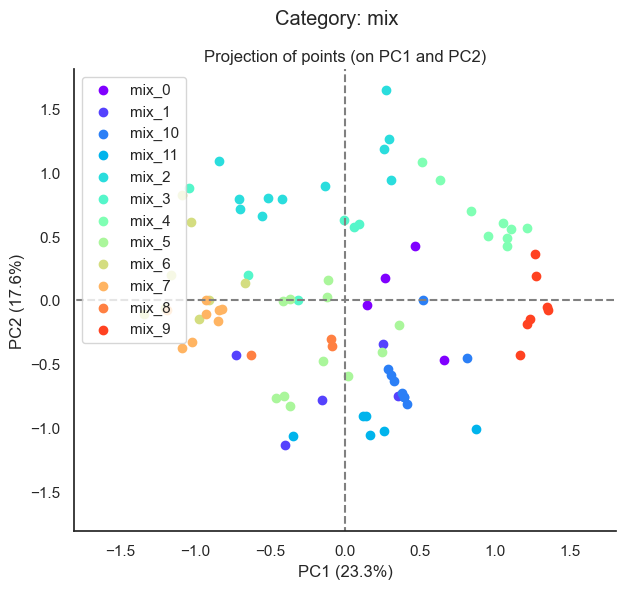

In [121]:
cat = "mix"
clustering.display_factorial_planes(pca_df.query(f"cat_pol == '{cat}'").to_numpy(), pca_results[f"{cat}"][0], [(0,1)], labels = pca_df.query(f"cat_pol == '{cat}'")["cluster"], 
    clust_labels = pca_df.query(f"cat_pol == '{cat}'")["cluster_id"], alpha = 1,  cmap = "rainbow")
plt.suptitle(f"Category: {cat}")
# clustering.display_circles(merged_output_df.filter(like = "PC").to_numpy(), len(pd.unique(merged_output_df["cluster"])), output_pca, [(0, 1)], labels = merged_output_df["cluster"], lims = [-2,2,-2,2])
# plot_df_tuning(pruned_df_nonscale, pruned_df_bGMM, [0, 1])

In [35]:
clust_labels

['on_0', 'on_1', 'on_2', 'on_3', 'on_4', 'on_5', 'on_6', 'on_7', 'on_8']

Text(0.5, 1.01, 'Category: on')

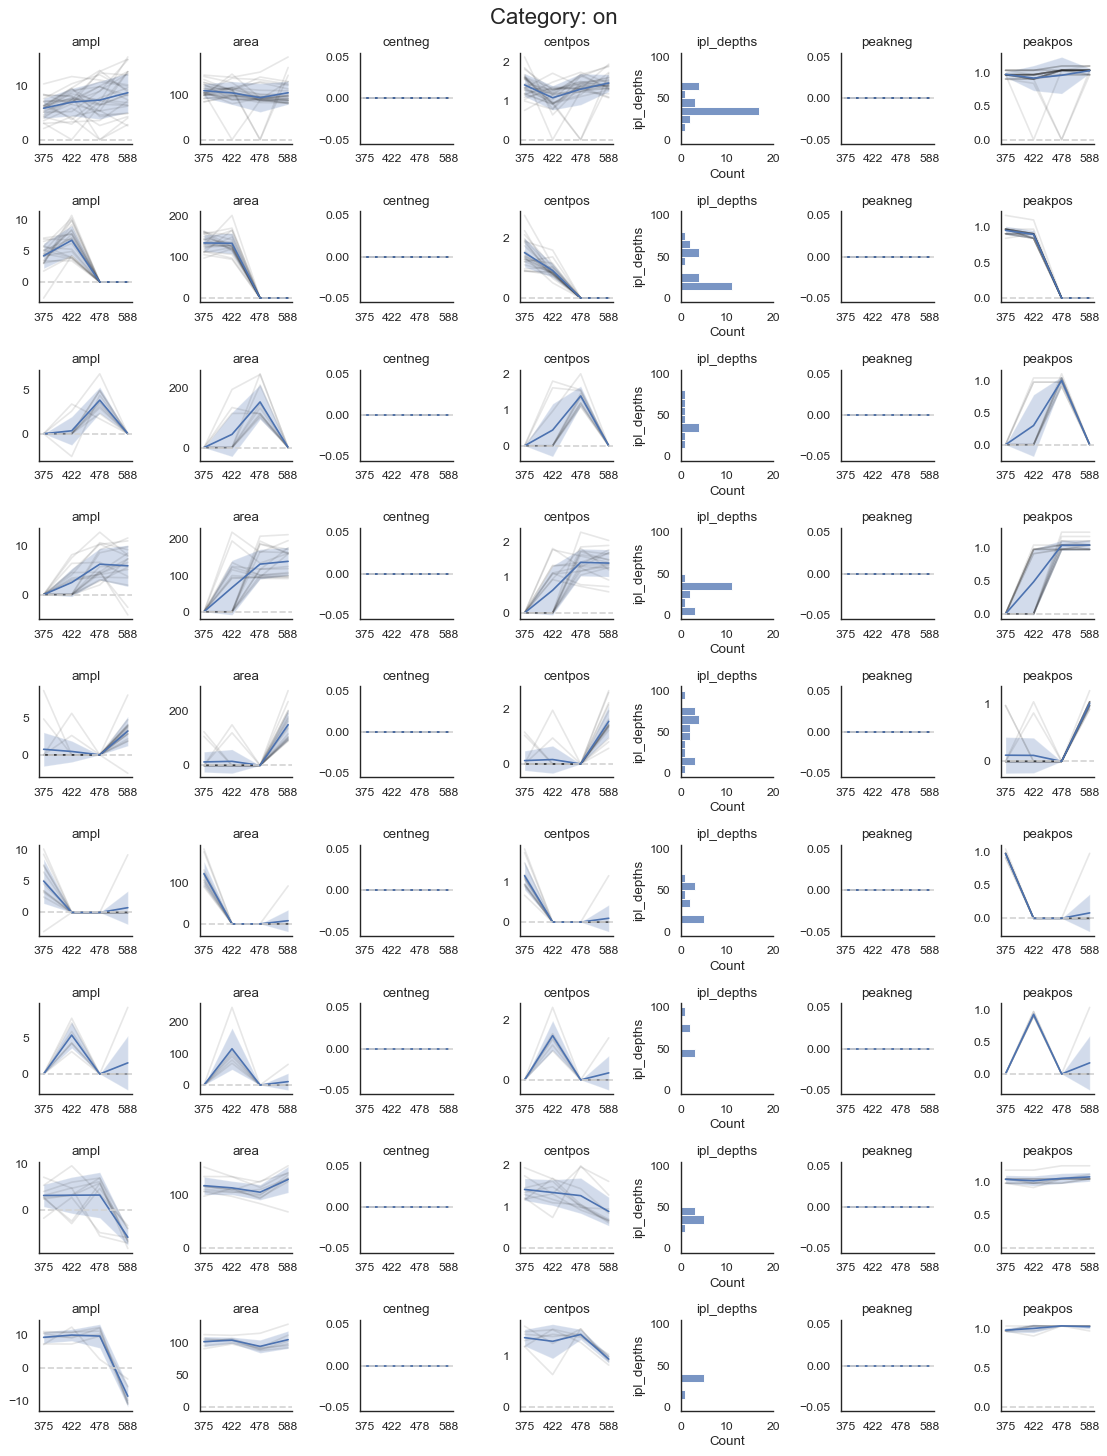

In [39]:
cat = "on"
# # Vizualize n clusters
clust_labels = pd.unique(pca_df.query(f'cat_pol == "{cat}"')["cluster"])
# print(np.unique(clust_labels))
# print(pd.unique(pca_df.query(f"cat_pol == '{cat}'")["cluster_id"]))
num_stats = 7
# # pruned_df.filter(regex = "ampl|area|cluster")
fig, ax = plt.subplots(len(clust_labels), num_stats, figsize = (num_stats*2, len(clust_labels)*2), dpi = 80)
for n, i in enumerate(clust_labels):
    clustering.plot_df_tuning(stats_df.query(f"cat_pol == '{cat}'").filter(regex = "ampl|area|cent|peak|ipl|cluster|cluster_id"), [i], ax = ax[n, 0:num_stats])
fig.tight_layout() #merged_stats_df
plt.suptitle(f"Category: {cat}", size = 20, y = 1.01)

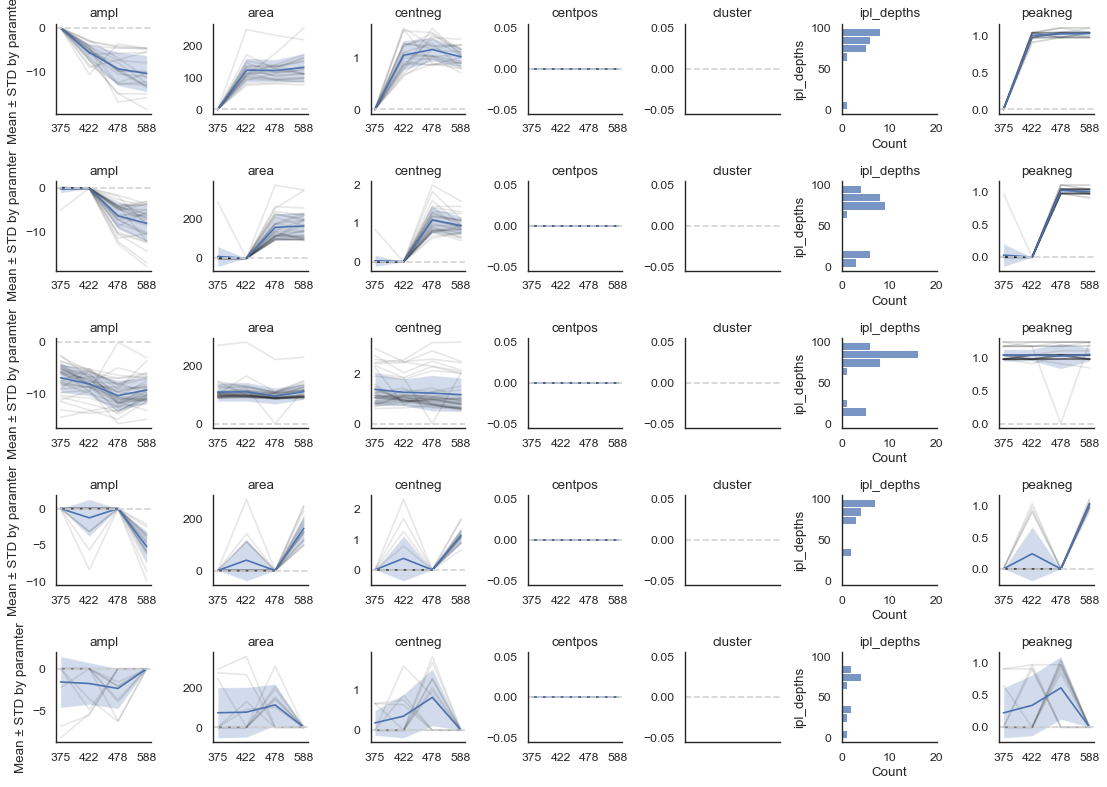

In [264]:
fig, ax = plt.subplots(len(clust_labels), num_stats, figsize = (num_stats*2, len(clust_labels)*2), dpi = 80)
for n, i in enumerate(clust_labels):
    plot_df_tuning(org_stats_df.query(f"cat_pol == '{cat}'").filter(regex = "ampl|area|cent|peak|ipl|cluster"), [i], ax = ax[n, 0:num_stats])
fig.tight_layout() #merged_stats_df

In [64]:
"""
TODO
- Get individual RFs by cluster
- The above plot but with option for passing raw data to clustering params --> can already do by labelling raw data?
        Either way, would be nice to be able to see both scaled and non-scaled representations, after clustering
- Need a script for getting the data from the raw STRFs that went into clustering, so I can plot averaged versions 
    by cluster type.
    --> Will require a bit of tinkering, as no raw STRF data is contained in the stats DFs. However, the file paths 
    should be there, so can go over and re-load pickled files as needed. 
- Implement seed for clustering wrappers
"""

'\nTODO\n- The above plot but with option for passing raw data to clustering params --> can already do by labelling raw data?\n        Either way, would be nice to be able to see both scaled and non-scaled representations, after clustering\n- Need a script for getting the data from the raw STRFs that went into clustering, so I can plot averaged versions \n    by cluster type.\n    --> Will require a bit of tinkering, as no raw STRF data is contained in the stats DFs. However, the file paths \n    should be there, so can go over and re-load pickled files as needed. \n'

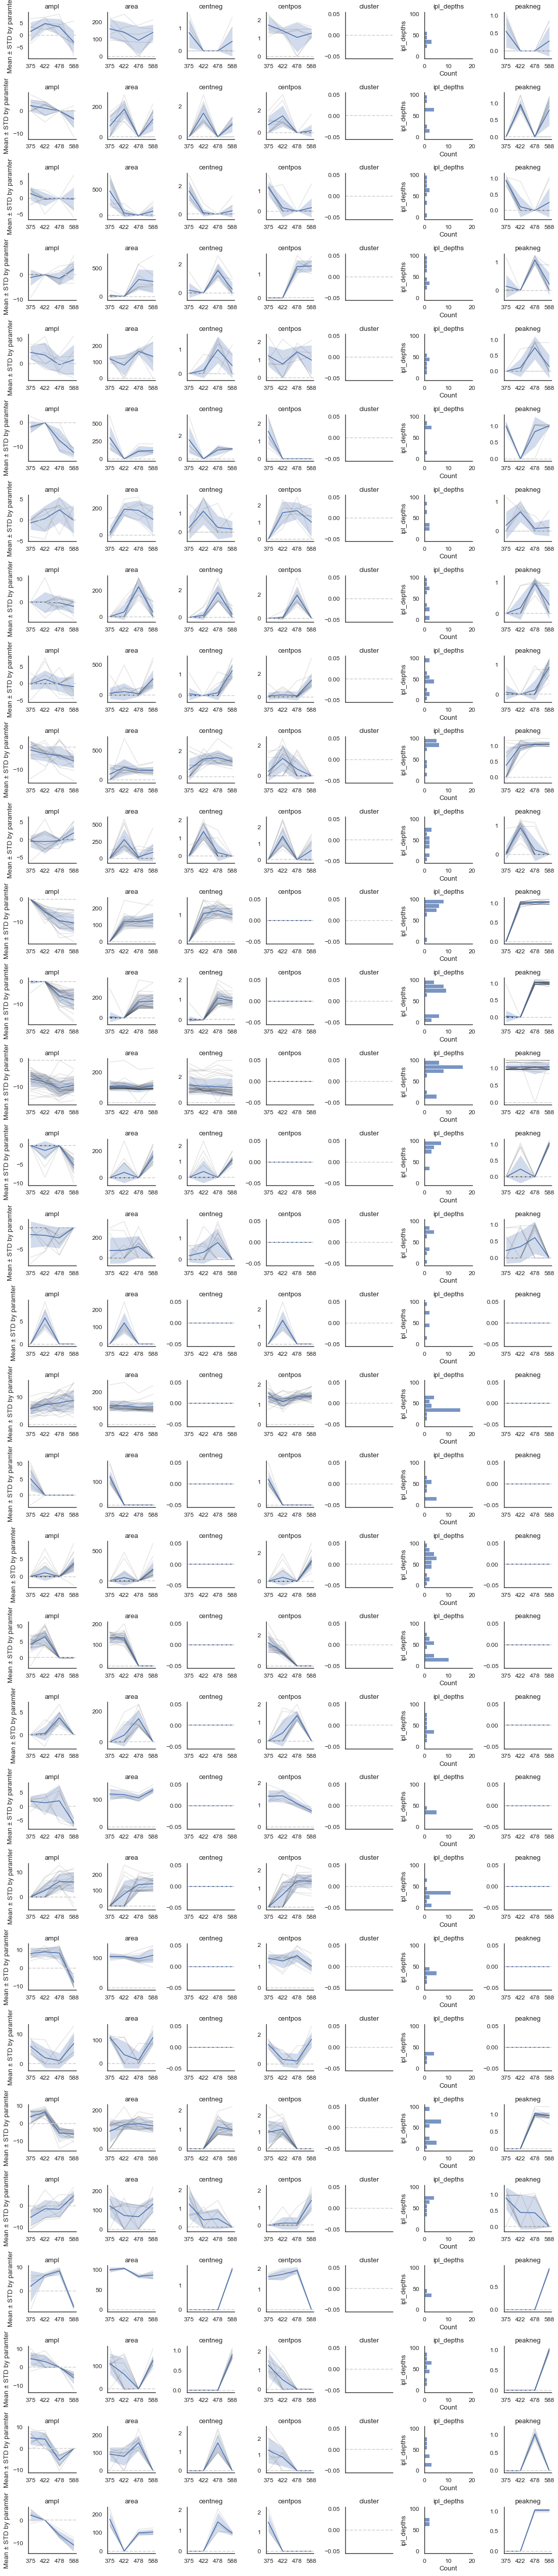

In [132]:
# # Vizualize n clusters
n_clust = len(pd.unique(scaled_df["cluster"]))
num_stats = 7
# pruned_df.filter(regex = "ampl|area|cluster")
fig, ax = plt.subplots(n_clust, num_stats, figsize = (num_stats*2, n_clust*2), dpi = 80)
for n, i in enumerate(range(n_clust)):
    plot_df_tuning(stats_df.filter(regex = "ampl|area|cent|peak|cluster|ipl"), i, ax = ax[n, 0:num_stats])
fig.tight_layout()

In [16]:
# ## Prepare data by cleaning and scaling, plus non scaled version of cleaned DF
# cluster_params = ["amp", "area", "peak", "cent"]
# # pruned_df[cols_like(["ampl"], pruned_df)]= sum_div_norm(pruned_df[cols_like(["ampl"], pruned_df)].values)
# pruned_df = prep_input_df(load_df, cluster_params, scaler = StandardScaler())
# ## Scale amplitude differentally
# # pruned_df[cols_like(["amp"], pruned_df)] = scale_data_points(pruned_df[cols_like(["amp"], pruned_df)])
# # Run PCA
# pruned_pca, pruned_df_pca = df_pca(pruned_df, whiten=True)
# # Run clustering on PCA result
# n_clust = 25
# pruned_df_clust = df_AggHierarchy(pruned_df_pca, n_clust)
# # Apply output by writing clusters to input data
# df_output = apply_clusters(pruned_df, pruned_df_clust)

## Create DF for visualising clustering results on original data
# stats_params =  ["ipl_depths"]
# stats_params.extend(clustering_params)
# stats_df = filehandling.split_df_by(load_df, "cat_pol")["off"]
# stats_df = prep_input_df(stats_df, stats_params, scaler = StandardScaler(), ignore_scale=cols_like([i for i in stats_params if i not in clustering_params], load_df))
# visualise_clust_df = apply_clusters(stats_df, merged_output_df)

# df_output["ipl_depths"] = visualise_clust_df["ipl_depths"].values


# plt.show()
# sns.boxplot(output_df, x = "cluster_id", y = "ipl_depths")
# plt.title("Distribution of cell IPL depth by cluster")
# # PCA for visualisation
clustering.display_factorial_planes(output_df.to_numpy(), pruned_pca, [(0,1)], labels = output_df["cluster_id"], 
    illustrative_var = output_df["cluster_id"], alpha = 1,  cmap = "rainbow")
# clustering.display_circles(pruned_df_pca.to_numpy(), 25, pruned_pca, [(0, 1)], labels = pruned_df_clust["cluster_id"], lims = [-2,2,-2,2])
# plot_df_tuning(pruned_df_nonscale, pruned_df_bGMM, [0, 1])

NameError: name 'output_df' is not defined

## TODO:
- [X] Figure out how to scale metrics independently, such that scaling is based in more "real" metrics (e.g., area cannot be negative). Don't worry too much about the spread in data/range, because the PCA step will take care of this and scale down to a comparative feature space
- [x] Create a metric for chromatic opponency such that equals: 'ON', 'OFF' or 'Mixed' depending on  (and 'Opponent?') tuning function
- [x] Then split data depending on this, such that you have a number of DFs equal to the number of above metric categories
- [X] Run PCA on data seperately, and combine cluster ID's into the original Dataframe such that cluster IDs are formatted:
    - ON_0, ON_1, etc... or Mixed_0, Mixed_1, etc...
    - Note: This means that there can be no ambigouity in the data! No cell must ever be in two groups, as this would break assigning of cluster_ID (at least in any sensible way)
- [ ] Implement a "delay" metric rather than peaktime, as this is more meaningful 
- [ ] "Stamp" or otherwise representative metrics collected from each cluster, presented as a single coherent plot 





^ Skrewing around with the clustering still. What I want to do is use MaxAbsScaler for some things like area but StanardScaler or otherwise for others. Need to look into sklearn pipelines, and maybe change the logic of prepping the DFs depending. 

Would be neat to be able to: 
- Give DF to cluster on 
- Give columns to use for clustering 
- Specficy columns to be scaled before clustering
- Specify how those columns are to be scaled 
- Return the entire DF after scaling and clustering with the cluster ID applied

Other notes for meeting:
- PG recordings --> Seems not bright enough, although also not very convincing with very bright Chrolis (Tess looking into this)
- Postponing PoorLabs switch until Tess tries neutral dentisty filters on Henry 
- Splitting by polarity then clustering --> Do I combine the PCAs first, or cluster everything seperate and just add together the cluster IDs?
- Can I apply scaling and transformations differently? 

In [ ]:
load_df["opp_bool"]

0      False
1       True
2       True
3      False
4       True
       ...  
476    False
477    False
478     True
479    False
480     True
Name: opp_bool, Length: 481, dtype: bool

In [ ]:
df_output

ampl_375  ampl_422  ampl_478  ampl_588  area_375  area_422  area_478  \
0         0.0 -0.226531  0.000000 -0.307263       0.0  0.385482  0.000000   
1         0.0  0.000000  0.000000 -0.135996       0.0  0.000000  0.000000   
2         0.0 -0.181742  0.146661  0.176834       0.0  0.238864  0.391953   
3         0.0  0.164371 -0.102937  0.000000       0.0  0.189804  0.290516   
4         0.0  0.000000  0.000000 -0.098776       0.0  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
389       0.0 -0.430485 -0.343558 -0.300678       0.0  0.172560  0.234815   
390       0.0  0.184639  0.188636 -0.209199       0.0  0.201366  0.190380   
391       0.0 -0.259342 -0.369005  0.000000       0.0  0.128804  0.176407   
392       0.0  0.000000  0.000000  0.154046       0.0  0.000000  0.000000   
393       0.0  0.000000  0.081625  0.000000       0.0  0.000000  0.519730   

     area_588  peakneg_375  peakneg_422  peakneg_478  peakneg_588  \
0    0.319103          0.0     0.842105     0.000000     0.894737   
1    0.279009          0.0     0.000000     0.000000     0.894737   
2    0.309864          0.0     0.684211     0.000000     0.000000   
3    0.000000          0.0     0.000000     0.842105     0.000000   
4    0.293403          0.0     0.000000     0.000000     0.315789   
..        ...          ...          ...          ...          ...   
389  0.208112          0.0     0.842105     0.842105     0.842105   
390  0.287286          0.0     0.000000     0.000000     0.578947   
391  0.000000          0.0     0.789474     0.789474     0.000000   
392  0.147291          0.0     0.000000     0.000000     0.000000   
393  0.000000          0.0     0.000000     0.631579     0.000000   

     peakpos_375  peakpos_422  peakpos_478  peakpos_588  cluster_id  
0            0.0     0.000000     0.000000     0.000000           9  
1            0.0     0.000000     0.000000     0.000000          20  
2            0.0     0.947368     0.842105     0.842105           4  
3            0.0     0.789474     0.000000     0.000000           5  
4            0.0     0.000000     0.000000     0.894737          21  
..           ...          ...          ...          ...         ...  
389          0.0     0.000000     0.000000     0.000000          23  
390          0.0     0.789474     0.842105     0.894737           4  
391          0.0     0.000000     0.000000     0.000000          23  
392          0.0     0.000000     0.000000     0.789474          21  
393          0.0     0.000000     0.947368     0.000000          24  

[394 rows x 17 columns]

In [ ]:
visualise_clust_df

ipl_depths  ampl_375  ampl_422  ampl_478  ampl_588  area_375  area_422  \
0          88.0  0.572257  0.410041  0.567789  0.379022       0.0  0.385482   
1          90.0  0.572257  0.530132  0.567789  0.472728       0.0  0.000000   
2          26.0  0.572257  0.433785  0.651061  0.643889       0.0  0.238864   
3          77.0  0.572257  0.617271  0.509343  0.547136       0.0  0.189804   
4          44.0  0.572257  0.530132  0.567789  0.493092       0.0  0.000000   
..          ...       ...       ...       ...       ...       ...       ...   
389        92.0  0.572257  0.301918  0.372720  0.382625       0.0  0.172560   
390        30.0  0.572257  0.628015  0.674894  0.432676       0.0  0.201366   
391        83.0  0.572257  0.392647  0.358272  0.547136       0.0  0.128804   
392        61.0  0.572257  0.530132  0.567789  0.631421       0.0  0.000000   
393        34.0  0.572257  0.530132  0.614135  0.547136       0.0  0.000000   

     area_478  area_588  peakneg_375  peakneg_422  peakneg_478  peakneg_588  \
0    0.000000  0.319103          0.0     0.842105     0.000000     0.894737   
1    0.000000  0.279009          0.0     0.000000     0.000000     0.894737   
2    0.391953  0.309864          0.0     0.684211     0.000000     0.000000   
3    0.290516  0.000000          0.0     0.000000     0.842105     0.000000   
4    0.000000  0.293403          0.0     0.000000     0.000000     0.315789   
..        ...       ...          ...          ...          ...          ...   
389  0.234815  0.208112          0.0     0.842105     0.842105     0.842105   
390  0.190380  0.287286          0.0     0.000000     0.000000     0.578947   
391  0.176407  0.000000          0.0     0.789474     0.789474     0.000000   
392  0.000000  0.147291          0.0     0.000000     0.000000     0.000000   
393  0.519730  0.000000          0.0     0.000000     0.631579     0.000000   

     peakpos_375  peakpos_422  peakpos_478  peakpos_588  cluster_id  
0            0.0     0.000000     0.000000     0.000000           9  
1            0.0     0.000000     0.000000     0.000000          20  
2            0.0     0.947368     0.842105     0.842105           4  
3            0.0     0.789474     0.000000     0.000000           5  
4            0.0     0.000000     0.000000     0.894737          21  
..           ...          ...          ...          ...         ...  
389          0.0     0.000000     0.000000     0.000000          23  
390          0.0     0.789474     0.842105     0.894737           4  
391          0.0     0.000000     0.000000     0.000000          23  
392          0.0     0.000000     0.000000     0.789474          21  
393          0.0     0.000000     0.947368     0.000000          24  

[394 rows x 18 columns]

TODO:

- Need to feature engineer a column that gives a boolean whether a cell is chromatically opponent or not